In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])

In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

153

***
## model training: finding number of iterations

In [8]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [9]:
model_params = {
    'boosting': 'dart',
    'linear_tree': True,
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'max_bin': 511,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 1.0,
    'drop_rate': 0.05,
    'feature_fraction': 0.15000000000000002,
    'lambda_l1': 3.2608153782775893,
    'lambda_l2': 24.65715474841406,
    'linear_lambda': 15.831719022196562,
    'max_drop': 5,
    'min_data_in_leaf': 2200,
    'num_iterations': 1900,
    'path_smooth': 4.714076496843463,
    'skip_drop': 0.65
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.897218	valid_0's pearsonr: 0.13006


[100]	valid_0's rmse: 0.896096	valid_0's pearsonr: 0.135368


[150]	valid_0's rmse: 0.895872	valid_0's pearsonr: 0.135524


[200]	valid_0's rmse: 0.895439	valid_0's pearsonr: 0.137999


[250]	valid_0's rmse: 0.895301	valid_0's pearsonr: 0.137872


[300]	valid_0's rmse: 0.895175	valid_0's pearsonr: 0.13736


[350]	valid_0's rmse: 0.894902	valid_0's pearsonr: 0.13877


[400]	valid_0's rmse: 0.894764	valid_0's pearsonr: 0.139495


[450]	valid_0's rmse: 0.894661	valid_0's pearsonr: 0.139485


[500]	valid_0's rmse: 0.894473	valid_0's pearsonr: 0.14038


[550]	valid_0's rmse: 0.894373	valid_0's pearsonr: 0.140965


[600]	valid_0's rmse: 0.894268	valid_0's pearsonr: 0.14165


[650]	valid_0's rmse: 0.894215	valid_0's pearsonr: 0.14165


[700]	valid_0's rmse: 0.894136	valid_0's pearsonr: 0.142167


[750]	valid_0's rmse: 0.894048	valid_0's pearsonr: 0.142772


[800]	valid_0's rmse: 0.893886	valid_0's pearsonr: 0.143986


[850]	valid_0's rmse: 0.893878	valid_0's pearsonr: 0.143954


[900]	valid_0's rmse: 0.893845	valid_0's pearsonr: 0.144131


[950]	valid_0's rmse: 0.893867	valid_0's pearsonr: 0.14392


[1000]	valid_0's rmse: 0.893802	valid_0's pearsonr: 0.144325


[1050]	valid_0's rmse: 0.893776	valid_0's pearsonr: 0.144506


[1100]	valid_0's rmse: 0.893727	valid_0's pearsonr: 0.144866


[1150]	valid_0's rmse: 0.893642	valid_0's pearsonr: 0.145505


[1200]	valid_0's rmse: 0.893628	valid_0's pearsonr: 0.145613


[1250]	valid_0's rmse: 0.89361	valid_0's pearsonr: 0.145745


[1300]	valid_0's rmse: 0.893595	valid_0's pearsonr: 0.145844


[1350]	valid_0's rmse: 0.893564	valid_0's pearsonr: 0.146079


[1400]	valid_0's rmse: 0.89354	valid_0's pearsonr: 0.146272


[1450]	valid_0's rmse: 0.893504	valid_0's pearsonr: 0.146556


[1500]	valid_0's rmse: 0.893488	valid_0's pearsonr: 0.146708


[1550]	valid_0's rmse: 0.893477	valid_0's pearsonr: 0.146813


[1600]	valid_0's rmse: 0.893519	valid_0's pearsonr: 0.146499


[1650]	valid_0's rmse: 0.893523	valid_0's pearsonr: 0.146516


[1700]	valid_0's rmse: 0.893529	valid_0's pearsonr: 0.146501


[1750]	valid_0's rmse: 0.893525	valid_0's pearsonr: 0.146573


[1800]	valid_0's rmse: 0.893498	valid_0's pearsonr: 0.146789


[1850]	valid_0's rmse: 0.893524	valid_0's pearsonr: 0.146654


[1900]	valid_0's rmse: 0.893477	valid_0's pearsonr: 0.147001


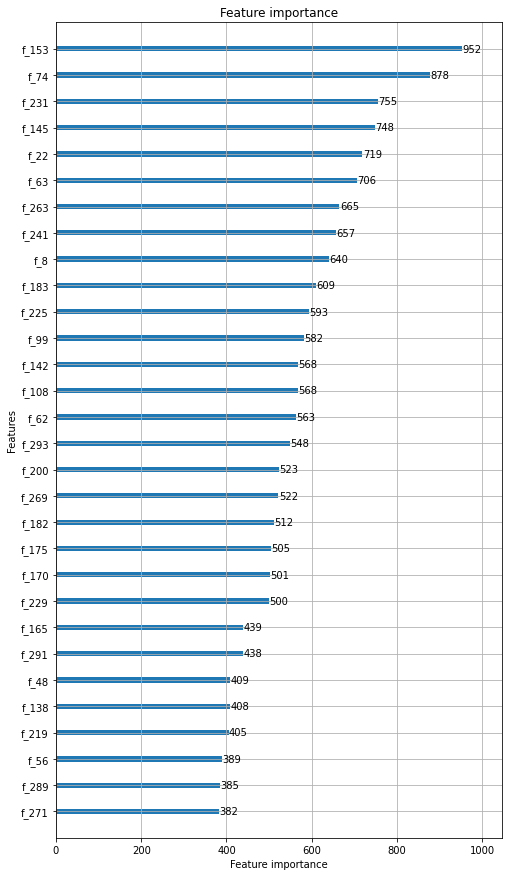

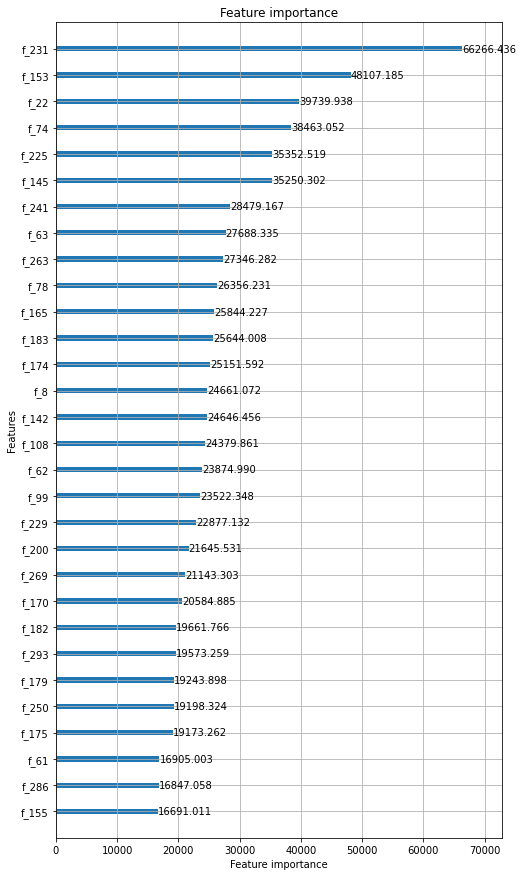

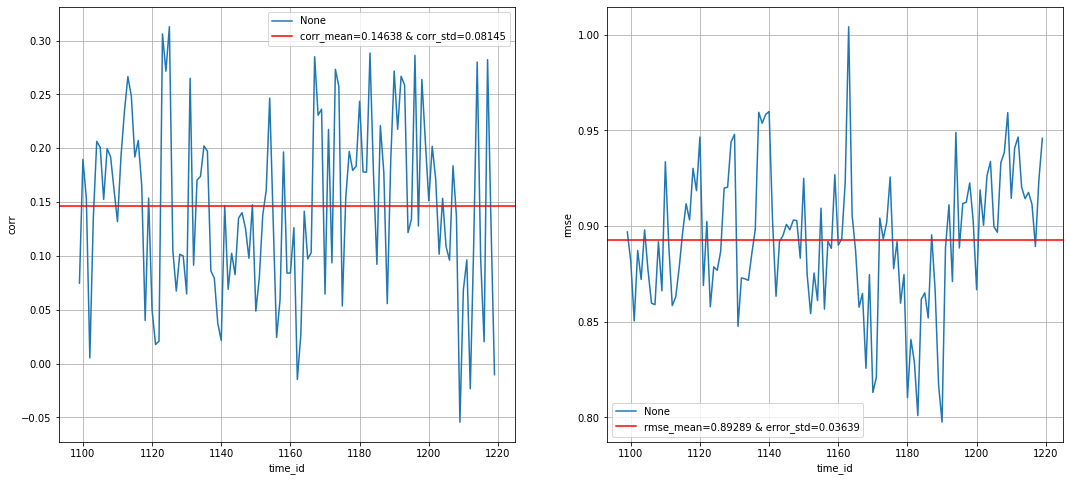

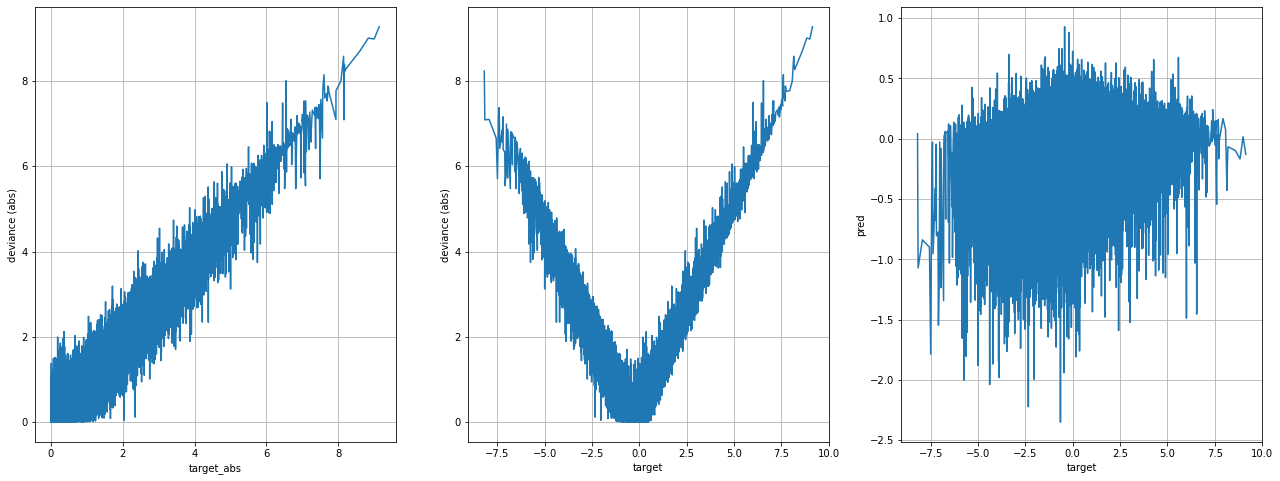

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.904836	valid_0's pearsonr: 0.119749


[100]	valid_0's rmse: 0.903486	valid_0's pearsonr: 0.129931


[150]	valid_0's rmse: 0.903017	valid_0's pearsonr: 0.133406


[200]	valid_0's rmse: 0.902625	valid_0's pearsonr: 0.135816


[250]	valid_0's rmse: 0.902333	valid_0's pearsonr: 0.137185


[300]	valid_0's rmse: 0.901986	valid_0's pearsonr: 0.138794


[350]	valid_0's rmse: 0.90172	valid_0's pearsonr: 0.140279


[400]	valid_0's rmse: 0.901547	valid_0's pearsonr: 0.141203


[450]	valid_0's rmse: 0.901367	valid_0's pearsonr: 0.1417


[500]	valid_0's rmse: 0.901244	valid_0's pearsonr: 0.141752


[550]	valid_0's rmse: 0.90121	valid_0's pearsonr: 0.141578


[600]	valid_0's rmse: 0.901097	valid_0's pearsonr: 0.14226


[650]	valid_0's rmse: 0.900995	valid_0's pearsonr: 0.142571


[700]	valid_0's rmse: 0.900926	valid_0's pearsonr: 0.142971


[750]	valid_0's rmse: 0.900892	valid_0's pearsonr: 0.143029


[800]	valid_0's rmse: 0.900837	valid_0's pearsonr: 0.143395


[850]	valid_0's rmse: 0.900806	valid_0's pearsonr: 0.143539


[900]	valid_0's rmse: 0.900803	valid_0's pearsonr: 0.143462


[950]	valid_0's rmse: 0.900802	valid_0's pearsonr: 0.143381


[1000]	valid_0's rmse: 0.900758	valid_0's pearsonr: 0.143594


[1050]	valid_0's rmse: 0.900709	valid_0's pearsonr: 0.143944


[1100]	valid_0's rmse: 0.900694	valid_0's pearsonr: 0.144029


[1150]	valid_0's rmse: 0.900676	valid_0's pearsonr: 0.144138


[1200]	valid_0's rmse: 0.900678	valid_0's pearsonr: 0.144125


[1250]	valid_0's rmse: 0.900671	valid_0's pearsonr: 0.144173


[1300]	valid_0's rmse: 0.900667	valid_0's pearsonr: 0.144195


[1350]	valid_0's rmse: 0.900675	valid_0's pearsonr: 0.144146


[1400]	valid_0's rmse: 0.900707	valid_0's pearsonr: 0.143964


[1450]	valid_0's rmse: 0.900708	valid_0's pearsonr: 0.143978


[1500]	valid_0's rmse: 0.900756	valid_0's pearsonr: 0.143676


[1550]	valid_0's rmse: 0.900762	valid_0's pearsonr: 0.14367


[1600]	valid_0's rmse: 0.900737	valid_0's pearsonr: 0.143846


[1650]	valid_0's rmse: 0.900783	valid_0's pearsonr: 0.143591


[1700]	valid_0's rmse: 0.900793	valid_0's pearsonr: 0.143612


[1750]	valid_0's rmse: 0.900841	valid_0's pearsonr: 0.143351


[1800]	valid_0's rmse: 0.900881	valid_0's pearsonr: 0.143117


[1850]	valid_0's rmse: 0.900881	valid_0's pearsonr: 0.143191


[1900]	valid_0's rmse: 0.900881	valid_0's pearsonr: 0.143209


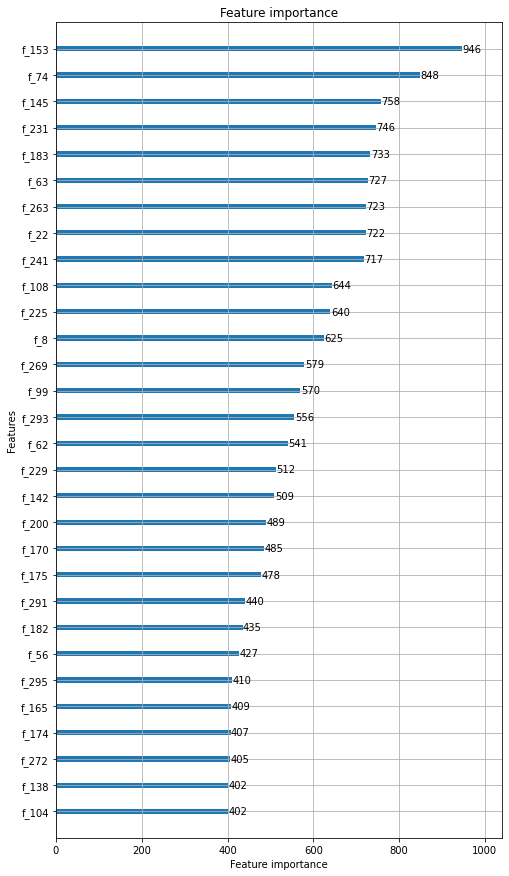

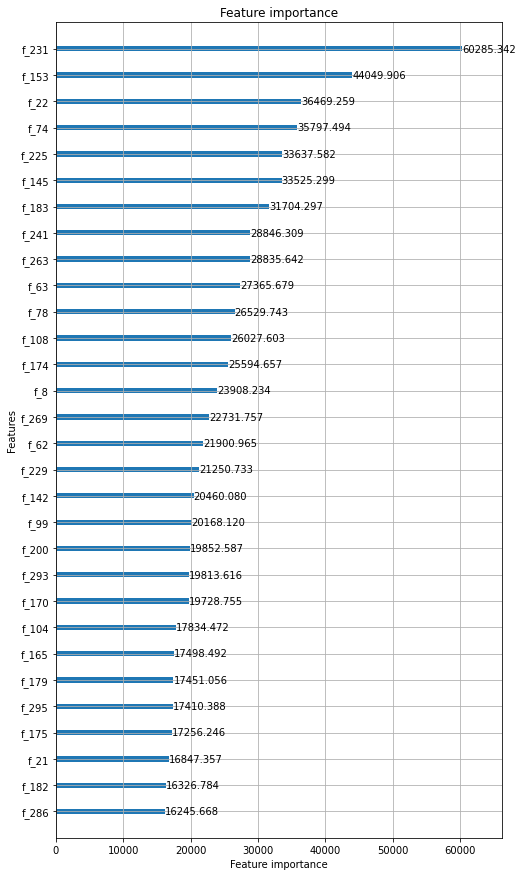

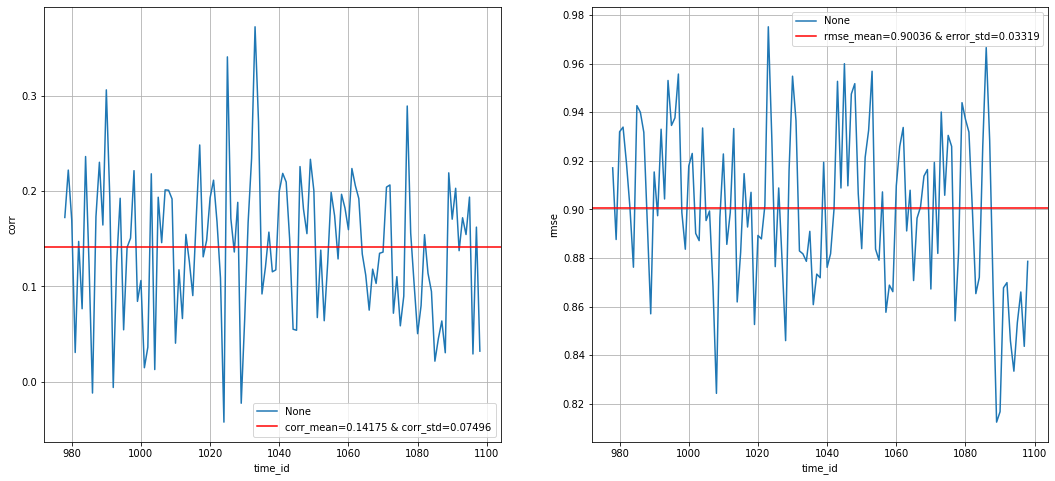

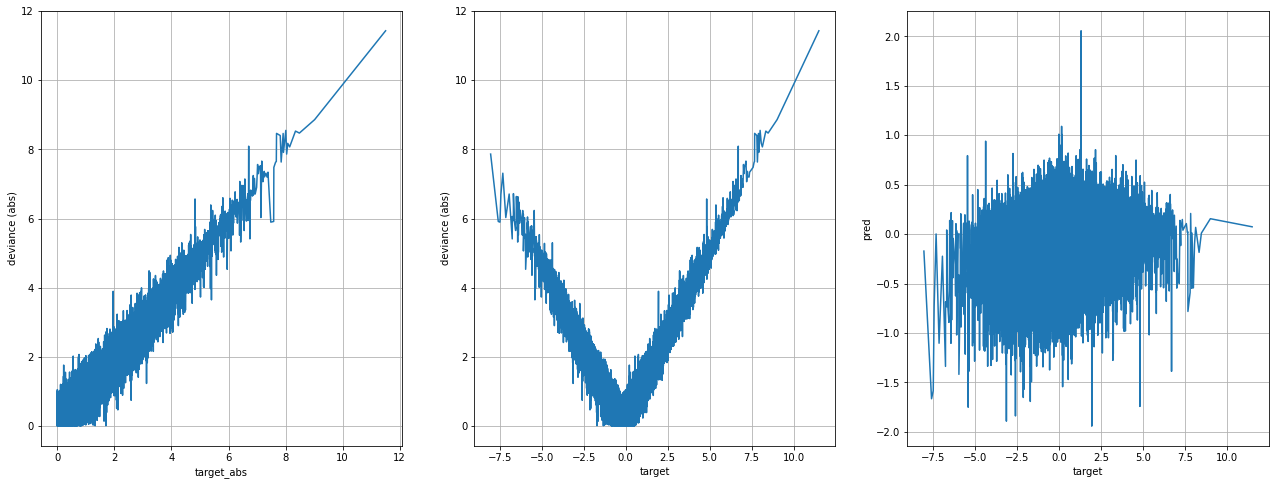

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.939403	valid_0's pearsonr: 0.102741


[100]	valid_0's rmse: 0.938319	valid_0's pearsonr: 0.112017


[150]	valid_0's rmse: 0.937885	valid_0's pearsonr: 0.115849


[200]	valid_0's rmse: 0.937425	valid_0's pearsonr: 0.119734


[250]	valid_0's rmse: 0.937064	valid_0's pearsonr: 0.122854


[300]	valid_0's rmse: 0.936676	valid_0's pearsonr: 0.12537


[350]	valid_0's rmse: 0.93642	valid_0's pearsonr: 0.12707


[400]	valid_0's rmse: 0.936172	valid_0's pearsonr: 0.128948


[450]	valid_0's rmse: 0.935892	valid_0's pearsonr: 0.130937


[500]	valid_0's rmse: 0.93571	valid_0's pearsonr: 0.13183


[550]	valid_0's rmse: 0.935493	valid_0's pearsonr: 0.133492


[600]	valid_0's rmse: 0.935334	valid_0's pearsonr: 0.134725


[650]	valid_0's rmse: 0.93517	valid_0's pearsonr: 0.135729


[700]	valid_0's rmse: 0.935085	valid_0's pearsonr: 0.136324


[750]	valid_0's rmse: 0.934932	valid_0's pearsonr: 0.137407


[800]	valid_0's rmse: 0.934839	valid_0's pearsonr: 0.138077


[850]	valid_0's rmse: 0.93469	valid_0's pearsonr: 0.139195


[900]	valid_0's rmse: 0.934568	valid_0's pearsonr: 0.140039


[950]	valid_0's rmse: 0.934449	valid_0's pearsonr: 0.140911


[1000]	valid_0's rmse: 0.934382	valid_0's pearsonr: 0.141308


[1050]	valid_0's rmse: 0.934318	valid_0's pearsonr: 0.141769


[1100]	valid_0's rmse: 0.934259	valid_0's pearsonr: 0.142169


[1150]	valid_0's rmse: 0.934194	valid_0's pearsonr: 0.142646


[1200]	valid_0's rmse: 0.934168	valid_0's pearsonr: 0.142838


[1250]	valid_0's rmse: 0.934101	valid_0's pearsonr: 0.143321


[1300]	valid_0's rmse: 0.934043	valid_0's pearsonr: 0.143735


[1350]	valid_0's rmse: 0.934	valid_0's pearsonr: 0.144049


[1400]	valid_0's rmse: 0.933938	valid_0's pearsonr: 0.144497


[1450]	valid_0's rmse: 0.933897	valid_0's pearsonr: 0.144803


[1500]	valid_0's rmse: 0.933837	valid_0's pearsonr: 0.145246


[1550]	valid_0's rmse: 0.933831	valid_0's pearsonr: 0.145306


[1600]	valid_0's rmse: 0.933789	valid_0's pearsonr: 0.14561


[1650]	valid_0's rmse: 0.933776	valid_0's pearsonr: 0.145728


[1700]	valid_0's rmse: 0.933764	valid_0's pearsonr: 0.145847


[1750]	valid_0's rmse: 0.933748	valid_0's pearsonr: 0.145996


[1800]	valid_0's rmse: 0.933713	valid_0's pearsonr: 0.146258


[1850]	valid_0's rmse: 0.933744	valid_0's pearsonr: 0.146082


[1900]	valid_0's rmse: 0.933737	valid_0's pearsonr: 0.146161


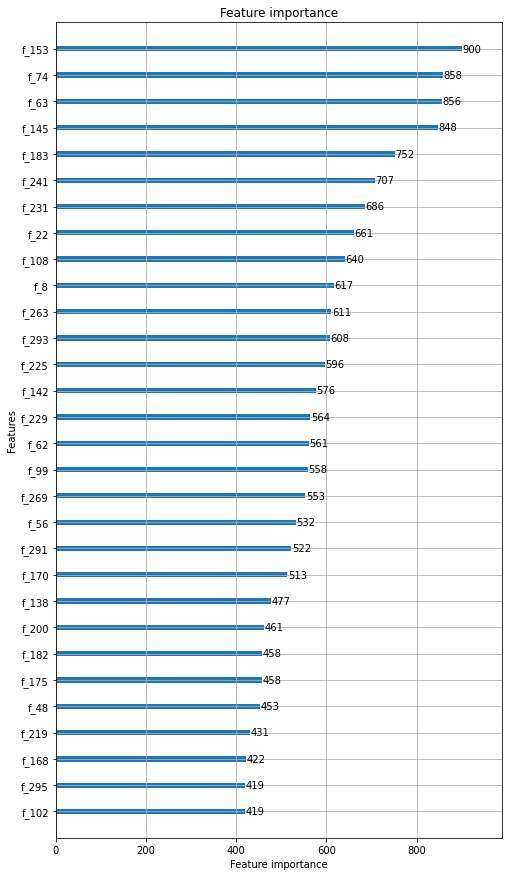

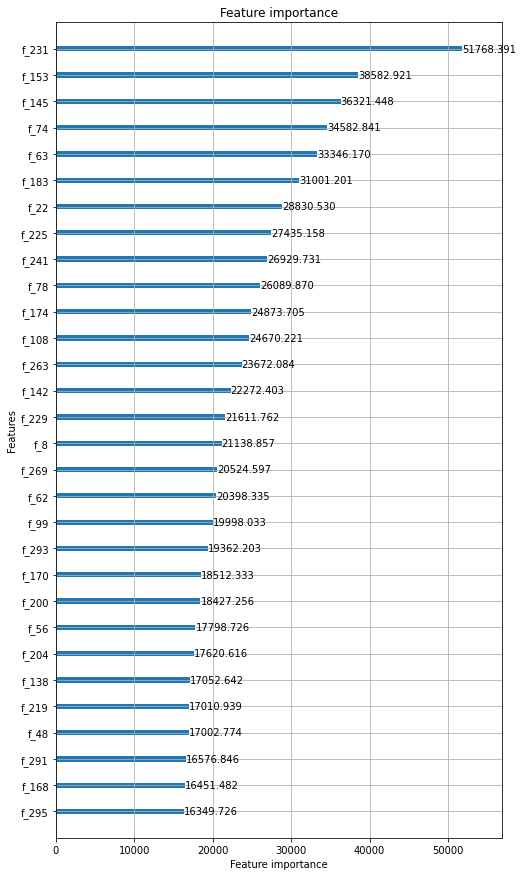

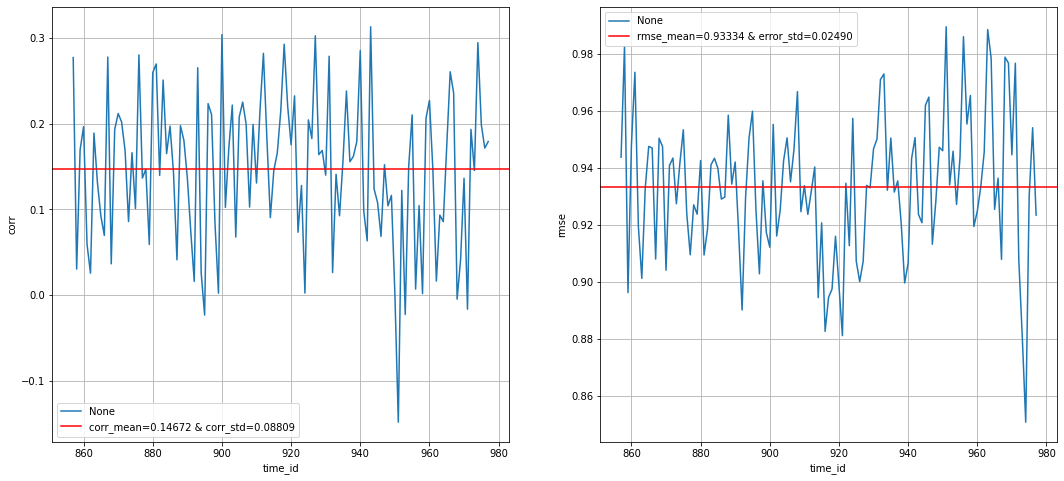

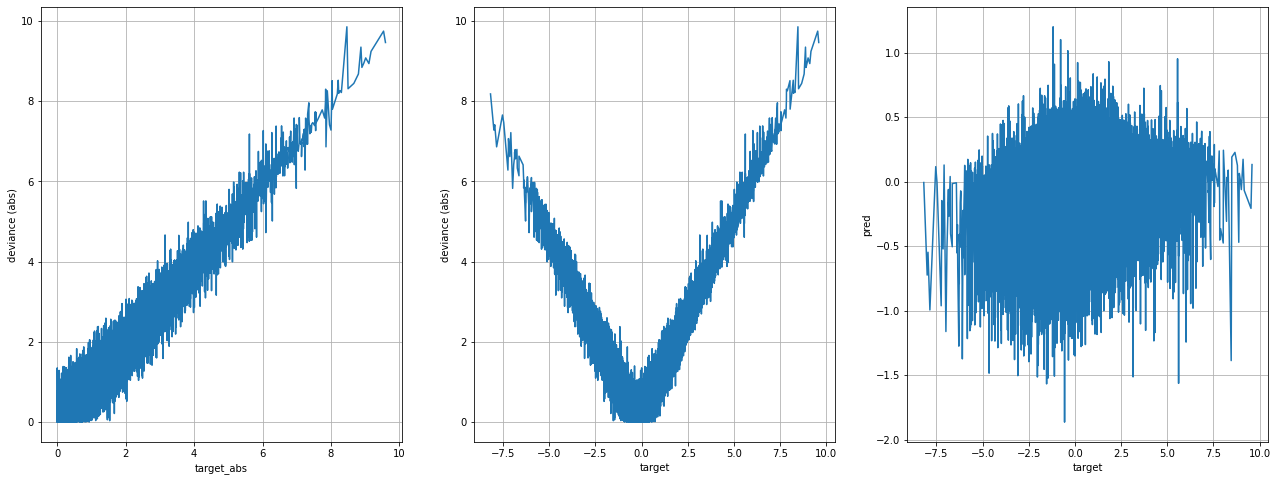

In [10]:
pretrain = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if pretrain:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )
    
        log_callback = lgb.log_evaluation(period=50,)
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=pearsonr,
            callbacks=[log_callback],
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()


In [11]:
metrics

{'corr_mean': [0.14638162548852635, 0.1417451467644637, 0.14672034749374893],
 'corr_std': [0.08145250369587288, 0.07496331729352496, 0.08808676876792683],
 'error_mean': [0.892889314686798, 0.9003586704541721, 0.933338764130531],
 'error_std': [0.0363937998364797, 0.033189338940492766, 0.02489679894617949]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.14494903991557964

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.908862249757167

***
## model training

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	training's rmse: 0.912256	training's pearsonr: 0.144375


[100]	training's rmse: 0.910699	training's pearsonr: 0.157651


[150]	training's rmse: 0.909201	training's pearsonr: 0.167287


[200]	training's rmse: 0.907673	training's pearsonr: 0.176568


[250]	training's rmse: 0.906242	training's pearsonr: 0.186881


[300]	training's rmse: 0.905	training's pearsonr: 0.19457


[350]	training's rmse: 0.904019	training's pearsonr: 0.200758


[400]	training's rmse: 0.903019	training's pearsonr: 0.207459


[450]	training's rmse: 0.901973	training's pearsonr: 0.213669


[500]	training's rmse: 0.900887	training's pearsonr: 0.219956


[550]	training's rmse: 0.900078	training's pearsonr: 0.224965


[600]	training's rmse: 0.89918	training's pearsonr: 0.230343


[650]	training's rmse: 0.898189	training's pearsonr: 0.23578


[700]	training's rmse: 0.897363	training's pearsonr: 0.240614


[750]	training's rmse: 0.896795	training's pearsonr: 0.244734


[800]	training's rmse: 0.896119	training's pearsonr: 0.248427


[850]	training's rmse: 0.895342	training's pearsonr: 0.252313


[900]	training's rmse: 0.894472	training's pearsonr: 0.256399


[950]	training's rmse: 0.893639	training's pearsonr: 0.260627


[1000]	training's rmse: 0.892876	training's pearsonr: 0.264676


[1050]	training's rmse: 0.892073	training's pearsonr: 0.268872


[1100]	training's rmse: 0.89135	training's pearsonr: 0.272554


[1150]	training's rmse: 0.890768	training's pearsonr: 0.27563


[1200]	training's rmse: 0.889956	training's pearsonr: 0.279335


[1250]	training's rmse: 0.88936	training's pearsonr: 0.282715


[1300]	training's rmse: 0.888723	training's pearsonr: 0.285781


[1350]	training's rmse: 0.888238	training's pearsonr: 0.288694


[1400]	training's rmse: 0.887726	training's pearsonr: 0.291656


[1450]	training's rmse: 0.887127	training's pearsonr: 0.294092


[1500]	training's rmse: 0.886496	training's pearsonr: 0.29687


[1550]	training's rmse: 0.885757	training's pearsonr: 0.299808


[1600]	training's rmse: 0.885172	training's pearsonr: 0.302696


[1650]	training's rmse: 0.884533	training's pearsonr: 0.305479


[1700]	training's rmse: 0.884163	training's pearsonr: 0.307912


[1750]	training's rmse: 0.883603	training's pearsonr: 0.310512


[1800]	training's rmse: 0.883074	training's pearsonr: 0.312722


[1850]	training's rmse: 0.88261	training's pearsonr: 0.315004


[1900]	training's rmse: 0.88214	training's pearsonr: 0.317439


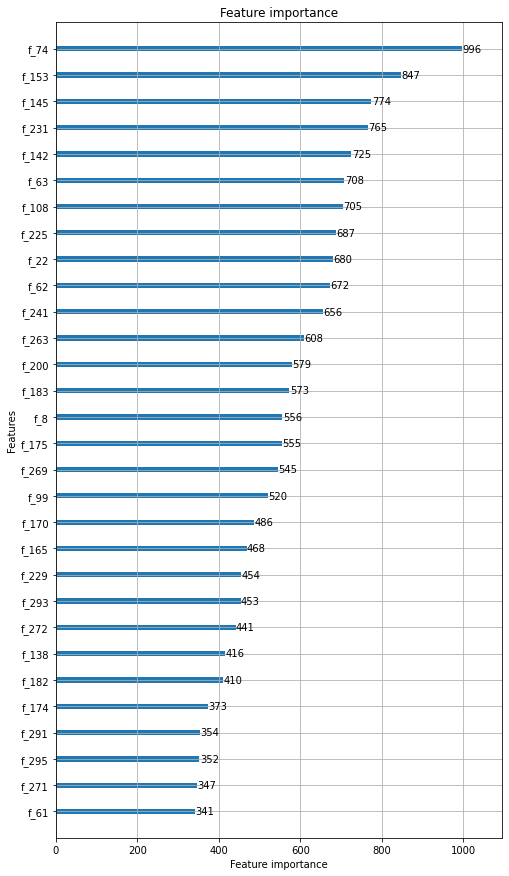

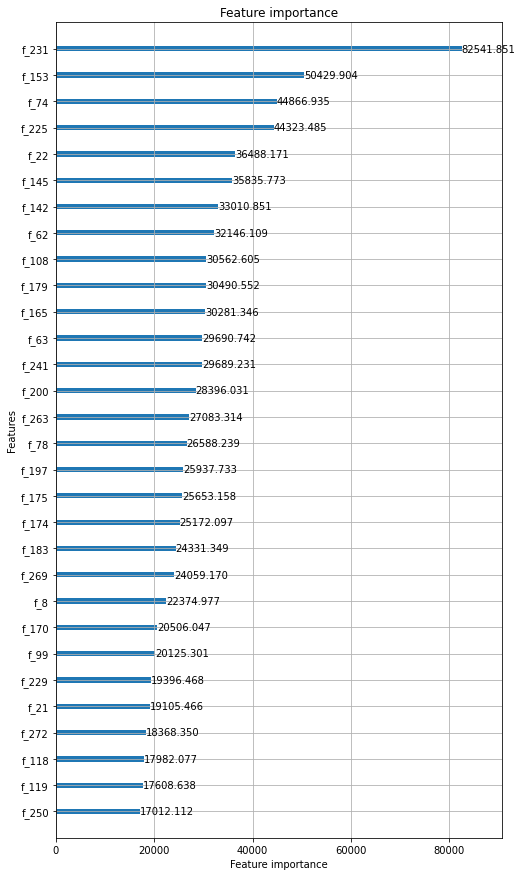

[50]	training's rmse: 0.912809	training's pearsonr: 0.142139


[100]	training's rmse: 0.910688	training's pearsonr: 0.155737


[150]	training's rmse: 0.909549	training's pearsonr: 0.164622


[200]	training's rmse: 0.907874	training's pearsonr: 0.175524


[250]	training's rmse: 0.906795	training's pearsonr: 0.183412


[300]	training's rmse: 0.905334	training's pearsonr: 0.192142


[350]	training's rmse: 0.904478	training's pearsonr: 0.198888


[400]	training's rmse: 0.903552	training's pearsonr: 0.20457


[450]	training's rmse: 0.902585	training's pearsonr: 0.210114


[500]	training's rmse: 0.901308	training's pearsonr: 0.216839


[550]	training's rmse: 0.900356	training's pearsonr: 0.223166


[600]	training's rmse: 0.899389	training's pearsonr: 0.228401


[650]	training's rmse: 0.898286	training's pearsonr: 0.234538


[700]	training's rmse: 0.897472	training's pearsonr: 0.239763


[750]	training's rmse: 0.896634	training's pearsonr: 0.244628


[800]	training's rmse: 0.895699	training's pearsonr: 0.249392


[850]	training's rmse: 0.895053	training's pearsonr: 0.253317


[900]	training's rmse: 0.894192	training's pearsonr: 0.258113


[950]	training's rmse: 0.893425	training's pearsonr: 0.262247


[1000]	training's rmse: 0.892818	training's pearsonr: 0.265675


[1050]	training's rmse: 0.892124	training's pearsonr: 0.268909


[1100]	training's rmse: 0.891699	training's pearsonr: 0.271764


[1150]	training's rmse: 0.8912	training's pearsonr: 0.274788


[1200]	training's rmse: 0.890428	training's pearsonr: 0.277689


[1250]	training's rmse: 0.889828	training's pearsonr: 0.280828


[1300]	training's rmse: 0.889129	training's pearsonr: 0.284035


[1350]	training's rmse: 0.888553	training's pearsonr: 0.286894


[1400]	training's rmse: 0.887947	training's pearsonr: 0.289962


[1450]	training's rmse: 0.88723	training's pearsonr: 0.293044


[1500]	training's rmse: 0.88663	training's pearsonr: 0.295998


[1550]	training's rmse: 0.88612	training's pearsonr: 0.298941


[1600]	training's rmse: 0.885444	training's pearsonr: 0.301672


[1650]	training's rmse: 0.884954	training's pearsonr: 0.304281


[1700]	training's rmse: 0.884437	training's pearsonr: 0.306885


[1750]	training's rmse: 0.883834	training's pearsonr: 0.309452


[1800]	training's rmse: 0.883268	training's pearsonr: 0.312131


[1850]	training's rmse: 0.882752	training's pearsonr: 0.314667


[1900]	training's rmse: 0.882323	training's pearsonr: 0.316614


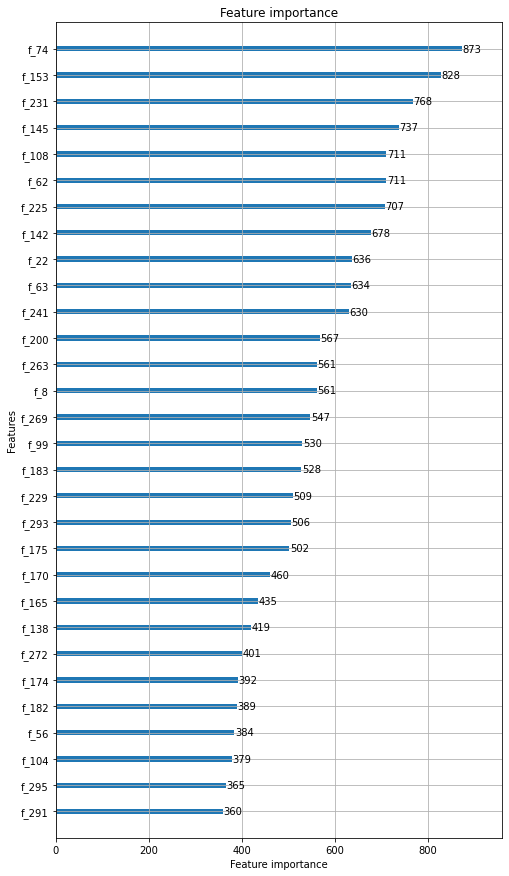

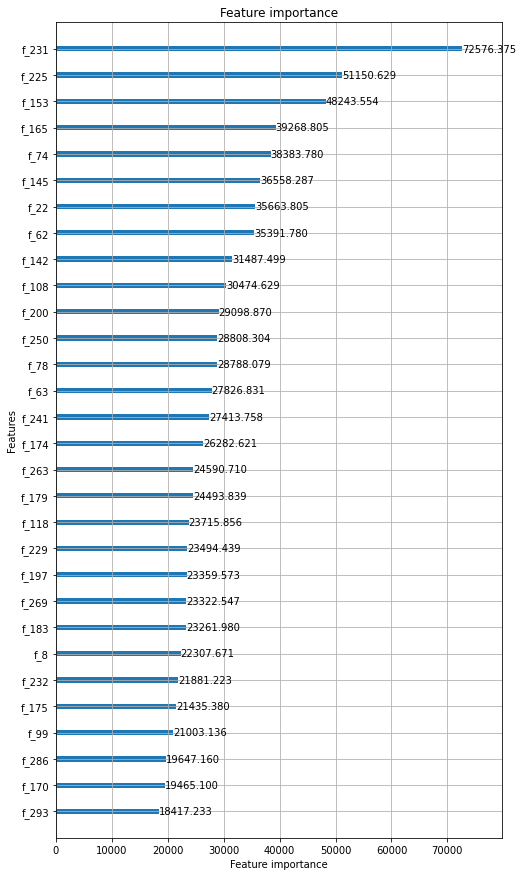

[50]	training's rmse: 0.913101	training's pearsonr: 0.139502


[100]	training's rmse: 0.910637	training's pearsonr: 0.155539


[150]	training's rmse: 0.909013	training's pearsonr: 0.16733


[200]	training's rmse: 0.907558	training's pearsonr: 0.177348


[250]	training's rmse: 0.906361	training's pearsonr: 0.185628


[300]	training's rmse: 0.905197	training's pearsonr: 0.193496


[350]	training's rmse: 0.903747	training's pearsonr: 0.201855


[400]	training's rmse: 0.903002	training's pearsonr: 0.208285


[450]	training's rmse: 0.902323	training's pearsonr: 0.213103


[500]	training's rmse: 0.901295	training's pearsonr: 0.218455


[550]	training's rmse: 0.900346	training's pearsonr: 0.224005


[600]	training's rmse: 0.89953	training's pearsonr: 0.229167


[650]	training's rmse: 0.898817	training's pearsonr: 0.233345


[700]	training's rmse: 0.897827	training's pearsonr: 0.238352


[750]	training's rmse: 0.897078	training's pearsonr: 0.242879


[800]	training's rmse: 0.896329	training's pearsonr: 0.247009


[850]	training's rmse: 0.895478	training's pearsonr: 0.251333


[900]	training's rmse: 0.894653	training's pearsonr: 0.255755


[950]	training's rmse: 0.893718	training's pearsonr: 0.260359


[1000]	training's rmse: 0.892891	training's pearsonr: 0.264554


[1050]	training's rmse: 0.892224	training's pearsonr: 0.268135


[1100]	training's rmse: 0.891512	training's pearsonr: 0.271736


[1150]	training's rmse: 0.890947	training's pearsonr: 0.274937


[1200]	training's rmse: 0.890434	training's pearsonr: 0.277822


[1250]	training's rmse: 0.889744	training's pearsonr: 0.28085


[1300]	training's rmse: 0.888985	training's pearsonr: 0.284285


[1350]	training's rmse: 0.888554	training's pearsonr: 0.287187


[1400]	training's rmse: 0.887928	training's pearsonr: 0.289901


[1450]	training's rmse: 0.887336	training's pearsonr: 0.292836


[1500]	training's rmse: 0.886669	training's pearsonr: 0.295742


[1550]	training's rmse: 0.886099	training's pearsonr: 0.298721


[1600]	training's rmse: 0.885517	training's pearsonr: 0.301472


[1650]	training's rmse: 0.884987	training's pearsonr: 0.303878


[1700]	training's rmse: 0.884492	training's pearsonr: 0.30634


[1750]	training's rmse: 0.884029	training's pearsonr: 0.308924


[1800]	training's rmse: 0.883613	training's pearsonr: 0.311078


[1850]	training's rmse: 0.883105	training's pearsonr: 0.313399


[1900]	training's rmse: 0.882678	training's pearsonr: 0.315396


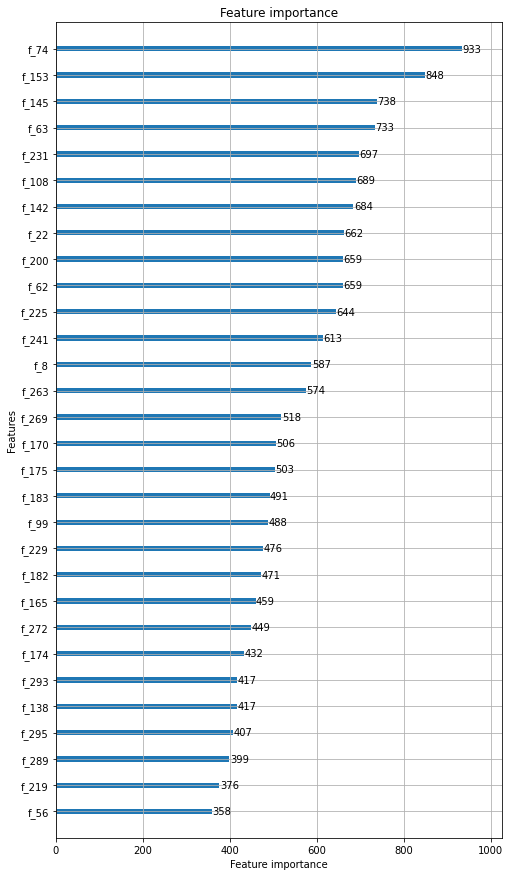

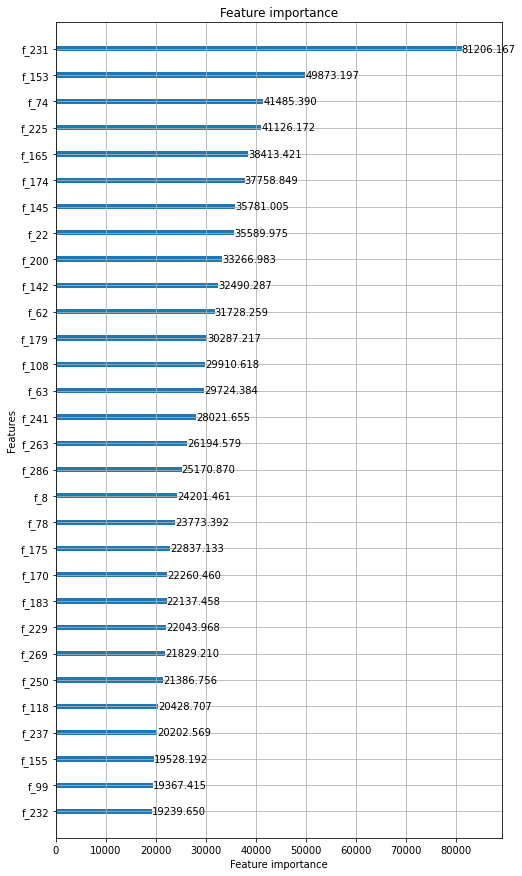

[50]	training's rmse: 0.912217	training's pearsonr: 0.144054


[100]	training's rmse: 0.909762	training's pearsonr: 0.161831


[150]	training's rmse: 0.908557	training's pearsonr: 0.171256


[200]	training's rmse: 0.907339	training's pearsonr: 0.180364


[250]	training's rmse: 0.906386	training's pearsonr: 0.186822


[300]	training's rmse: 0.905146	training's pearsonr: 0.194562


[350]	training's rmse: 0.904005	training's pearsonr: 0.201891


[400]	training's rmse: 0.90305	training's pearsonr: 0.208085


[450]	training's rmse: 0.90197	training's pearsonr: 0.214299


[500]	training's rmse: 0.900872	training's pearsonr: 0.219959


[550]	training's rmse: 0.899853	training's pearsonr: 0.226118


[600]	training's rmse: 0.898948	training's pearsonr: 0.231811


[650]	training's rmse: 0.89777	training's pearsonr: 0.237672


[700]	training's rmse: 0.897082	training's pearsonr: 0.242035


[750]	training's rmse: 0.896226	training's pearsonr: 0.246667


[800]	training's rmse: 0.895458	training's pearsonr: 0.251244


[850]	training's rmse: 0.894695	training's pearsonr: 0.255563


[900]	training's rmse: 0.893987	training's pearsonr: 0.259296


[950]	training's rmse: 0.893303	training's pearsonr: 0.263075


[1000]	training's rmse: 0.892359	training's pearsonr: 0.266973


[1050]	training's rmse: 0.891668	training's pearsonr: 0.270832


[1100]	training's rmse: 0.890963	training's pearsonr: 0.274442


[1150]	training's rmse: 0.890345	training's pearsonr: 0.277754


[1200]	training's rmse: 0.889916	training's pearsonr: 0.280585


[1250]	training's rmse: 0.889361	training's pearsonr: 0.283476


[1300]	training's rmse: 0.888709	training's pearsonr: 0.286527


[1350]	training's rmse: 0.888069	training's pearsonr: 0.289341


[1400]	training's rmse: 0.887332	training's pearsonr: 0.292648


[1450]	training's rmse: 0.886853	training's pearsonr: 0.295471


[1500]	training's rmse: 0.886197	training's pearsonr: 0.298273


[1550]	training's rmse: 0.885638	training's pearsonr: 0.300945


[1600]	training's rmse: 0.885254	training's pearsonr: 0.303319


[1650]	training's rmse: 0.884627	training's pearsonr: 0.305876


[1700]	training's rmse: 0.883999	training's pearsonr: 0.30845


[1750]	training's rmse: 0.88342	training's pearsonr: 0.311041


[1800]	training's rmse: 0.882915	training's pearsonr: 0.313568


[1850]	training's rmse: 0.882374	training's pearsonr: 0.315802


[1900]	training's rmse: 0.881914	training's pearsonr: 0.318227


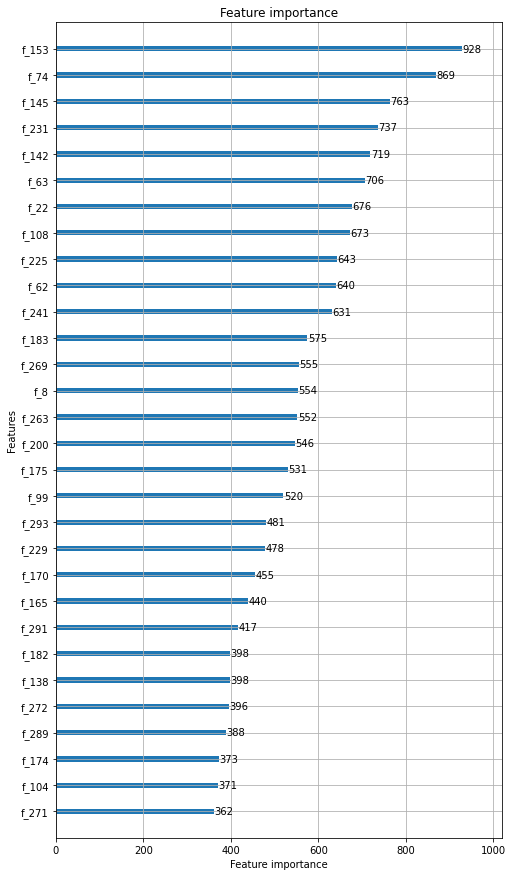

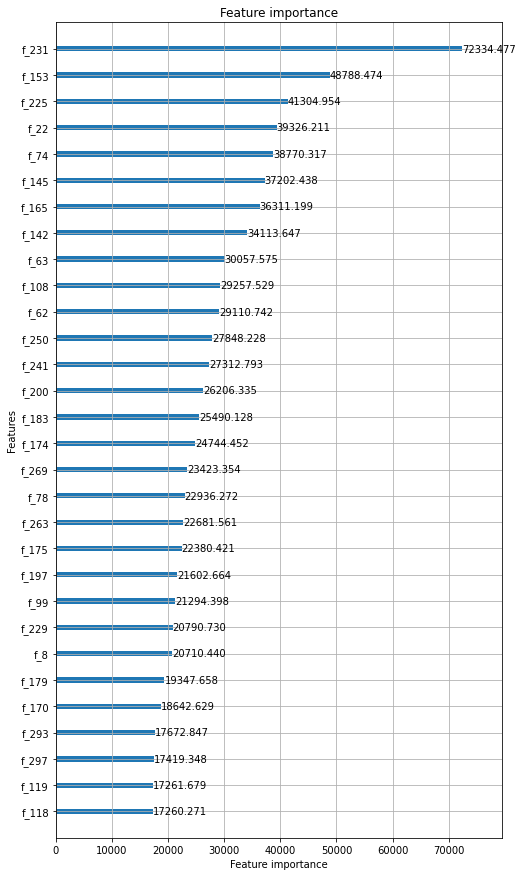

[50]	training's rmse: 0.912494	training's pearsonr: 0.142957


[100]	training's rmse: 0.909861	training's pearsonr: 0.159898


[150]	training's rmse: 0.908586	training's pearsonr: 0.171512


[200]	training's rmse: 0.907164	training's pearsonr: 0.179868


[250]	training's rmse: 0.905689	training's pearsonr: 0.189205


[300]	training's rmse: 0.904766	training's pearsonr: 0.196326


[350]	training's rmse: 0.903824	training's pearsonr: 0.20319


[400]	training's rmse: 0.902545	training's pearsonr: 0.210201


[450]	training's rmse: 0.901486	training's pearsonr: 0.216297


[500]	training's rmse: 0.900649	training's pearsonr: 0.221689


[550]	training's rmse: 0.899678	training's pearsonr: 0.22735


[600]	training's rmse: 0.898631	training's pearsonr: 0.233084


[650]	training's rmse: 0.897745	training's pearsonr: 0.238431


[700]	training's rmse: 0.897087	training's pearsonr: 0.242911


[750]	training's rmse: 0.896307	training's pearsonr: 0.24707


[800]	training's rmse: 0.895254	training's pearsonr: 0.251999


[850]	training's rmse: 0.894278	training's pearsonr: 0.256825


[900]	training's rmse: 0.893738	training's pearsonr: 0.260686


[950]	training's rmse: 0.893117	training's pearsonr: 0.264285


[1000]	training's rmse: 0.892347	training's pearsonr: 0.267879


[1050]	training's rmse: 0.891463	training's pearsonr: 0.271851


[1100]	training's rmse: 0.890832	training's pearsonr: 0.275348


[1150]	training's rmse: 0.89006	training's pearsonr: 0.278962


[1200]	training's rmse: 0.889461	training's pearsonr: 0.282224


[1250]	training's rmse: 0.888911	training's pearsonr: 0.285123


[1300]	training's rmse: 0.888496	training's pearsonr: 0.287855


[1350]	training's rmse: 0.887741	training's pearsonr: 0.290672


[1400]	training's rmse: 0.887083	training's pearsonr: 0.294021


[1450]	training's rmse: 0.886466	training's pearsonr: 0.296889


[1500]	training's rmse: 0.885758	training's pearsonr: 0.299859


[1550]	training's rmse: 0.885242	training's pearsonr: 0.302737


[1600]	training's rmse: 0.884652	training's pearsonr: 0.305449


[1650]	training's rmse: 0.883981	training's pearsonr: 0.308321


[1700]	training's rmse: 0.883556	training's pearsonr: 0.310825


[1750]	training's rmse: 0.882959	training's pearsonr: 0.313355


[1800]	training's rmse: 0.882298	training's pearsonr: 0.316017


[1850]	training's rmse: 0.88186	training's pearsonr: 0.318442


[1900]	training's rmse: 0.881364	training's pearsonr: 0.320753


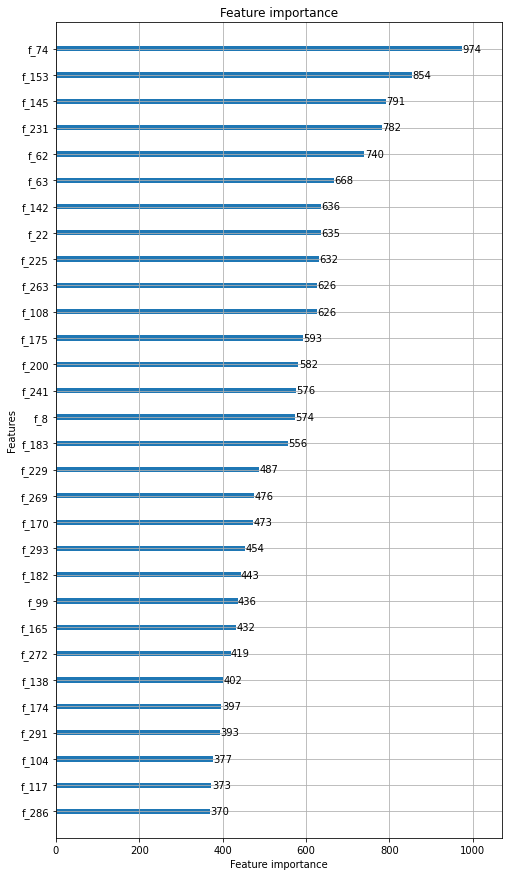

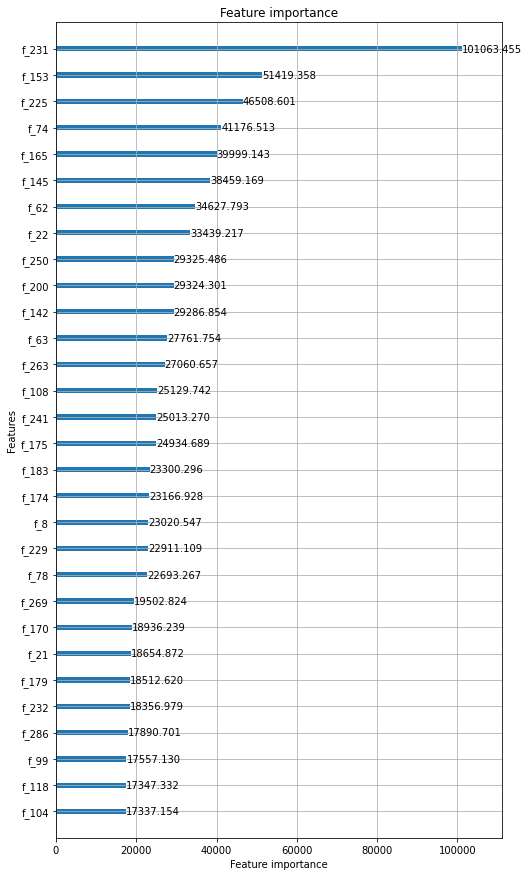

In [14]:
seeds = [2,7,11,19,23]
models = list()

train_dset = lgb.Dataset(
    data=features,
    label=target.target.values,
    free_raw_data=True
)

for seed in seeds:
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    
    log_callback = lgb.log_evaluation(period=50)
    
    model = lgb.train(
        params=_model_params,
        train_set=train_dset,
        valid_sets=[train_dset,],
        feval=pearsonr,
        callbacks=[log_callback,]
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [15]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/lgbm-linear-dart/lgbm-seed{seed}.txt")

***
## inference

In [16]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***